In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection, jones_2009_model
from hnn_core.cells_default import _exp_g_at_dist, _linear_g_at_dist
from hnn_core.network_models import add_erp_drives_to_jones_model
from functools import partial
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

### Create base network with standard ERP drives and new NMDA synapses

In [17]:
l_contra_params = read_params('../data/L_Contra.param')
net_base = calcium_model(params=l_contra_params, add_drives_from_params=True)

# net_base = jones_2009_model()
# add_erp_drives_to_jones_model(net_base)

In [18]:
# Dendritic Km sweep
def L5_pyramidal_km_dend(net, scale=0.0):
    for sec_name, sec in net.cell_types['L5_pyramidal']['cell_object'].sections.items():
        if sec_name != 'soma':
            sec.mechs['km']['gbar_km'] *= (10 ** scale)


# Inhibitory gain sweep
def inhibitory_gain(net, scale=0.0):
    conn_indices = pick_connection(net, target_gids=['L2_basket', 'L5_basket'], receptor=['gabaa'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale

# Feedforward gain sweep
def feedforward_gain(net, scale=0.0):
    conn_indices = pick_connection(net, src_gids=['evprox1', 'evprox2'])
    for conn_idx in conn_indices:
        net.connectivity[conn_idx]['nc_dict']['A_weight'] *= 10 ** scale

def run_simulation(net_base, theta_i, prior_dict, return_net=False):
    assert len(theta_i) == len(prior_dict)

    net = net_base.copy()
    for param_idx, param_name in enumerate(prior_dict.keys()):
        update_function = prior_dict[param_name]['update_function']
        update_function(net, theta_i[param_idx])

    dpl = simulate_dipole(net, tstop=tstop, dt=dt, n_trials=1)
    dpl_data = dpl[0].copy().smooth(30).data['agg']

    if return_net:
        return (net, dpl_data)
    else:
        return dpl_data


In [20]:
min_val, max_val = 0, 1

prior_dict = {
    'feedforward_gain': {'bounds': (min_val, max_val), 'update_function': feedforward_gain, 'mech_name': 'Feedforward gain'},
    'L5_pyramidal_km_dend': {'bounds': (min_val, max_val), 'update_function': L5_pyramidal_km_dend, 'mech_name': 'Dendritic Km'},
    'inhibitory_gain': {'bounds': (min_val, max_val), 'update_function': inhibitory_gain, 'mech_name': 'GABA disinhibition'},

}

num_params = len(prior_dict)
sweep_len = 2

theta = np.zeros((num_params * sweep_len, num_params))
labels = list()
for param_idx, param_name in enumerate(prior_dict.keys()):
    min_val, max_val = prior_dict[param_name]['bounds']
    sweep_values = np.linspace(min_val, max_val, sweep_len)

    start_idx = param_idx * sweep_len
    stop_idx = start_idx + sweep_len
    theta[start_idx:stop_idx, param_idx] = sweep_values

    labels.extend(np.repeat(prior_dict[param_name]['mech_name'], sweep_len).tolist())


In [21]:
tstop = 200
dt = 0.025

res = Parallel(n_jobs=50)(delayed(run_simulation)(
    net_base, theta[idx,:],prior_dict, return_net=True) for idx in range(theta.shape[0]))


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2

In [22]:
df_dict = {
    'net': [res[idx][0] for idx in range(len(res))],
    'dpl': [res[idx][1] for idx in range(len(res))],
    'label': labels,
    'theta': theta.tolist()}
df = pd.DataFrame(df_dict)

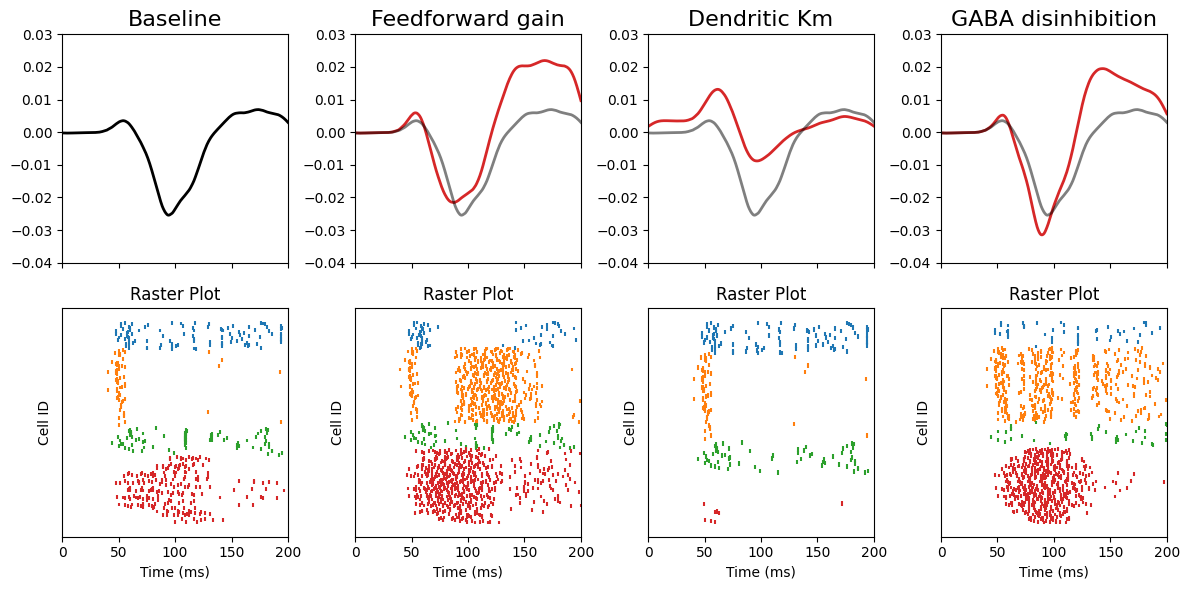

In [24]:
ticksize = 13
labelsize = 14
titlesize = 16

plot_lookup = [
    {'label': 'Feedforward gain', 'idx': 0, 'name': 'Baseline'},
    {'label': 'Feedforward gain', 'idx': 1, 'name': 'Feedforward gain'},
    {'label': 'Dendritic Km', 'idx': 1, 'name': 'Dendritic Km'},
    {'label': 'GABA disinhibition', 'idx': 1, 'name': 'GABA disinhibition'}
]

times = np.linspace(0, tstop, len(res[0][1]))

fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True)
for plot_idx, plot_dict in enumerate(plot_lookup):

    net = df[df['label'] == plot_dict['label']]['net'].values[plot_dict['idx']]
    dpl = df[df['label'] == plot_dict['label']]['dpl'].values[plot_dict['idx']]

    dpl_baseline = df[df['label'] == 'Feedforward gain']['dpl'].values[0]
    
    if plot_idx > 0:
        axes[0, plot_idx].plot(times, dpl, linewidth=2, color=f'C3')
        axes[0, plot_idx].plot(times, dpl_baseline, linewidth=2, color='k', alpha=0.5)
    else: 
        axes[0, plot_idx].plot(times, dpl_baseline, linewidth=2, color='k')

    axes[0, plot_idx].set_title(plot_dict['name'], fontsize=titlesize)
    axes[0, plot_idx].set_ylim(-0.04, 0.03)

    net.cell_response.plot_spikes_raster(ax=axes[1, plot_idx], show=False, show_legend=False)

    # net.cell_response.plot_spikes_hist(ax=axes[0, plot_idx],
    #     spike_types={'Proximal': ['evprox1', 'evprox2'], 'Distal': ['evdist1']}, show=False, invert_spike_types='Distal')

plt.tight_layout()


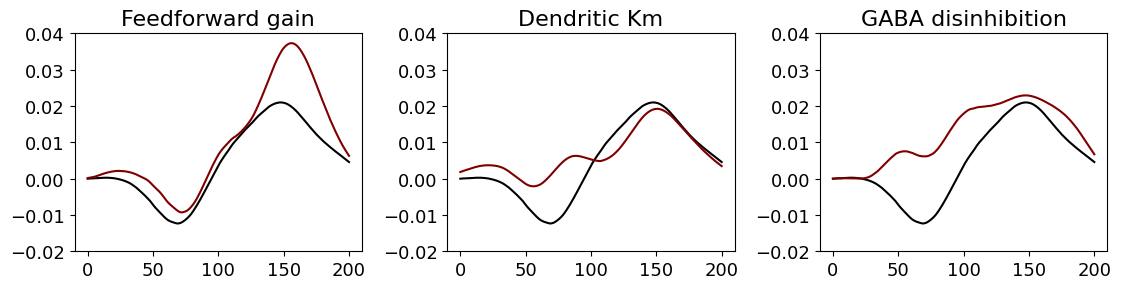

In [7]:
ticksize = 13
labelsize = 14
titlesize = 16

unique_labels = df['label'].unique()
times = np.linspace(0, tstop, len(res[0]))

plt.figure(figsize=(15,3))
for plot_idx, label_name in enumerate(unique_labels):

    cmap_color = 'r'
    colors = ['k', cmap_color] # first color is black, last is red
    cmap = LinearSegmentedColormap.from_list(
            "Custom", colors)

    plt.subplot(1, 4, plot_idx+1)
    mask = df['label'] == label_name
    dpl_data = df[mask]['dpl'].values

    for sim_idx in range(sweep_len):
        sweep_color = cmap(sim_idx / sweep_len)
        plt.plot(times, dpl_data[sim_idx], linewidth=1.5, color=sweep_color)

    plt.title(label_name, fontsize=titlesize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)

    plt.ylim(-0.02, 0.04)


plt.tight_layout()